### Image Deblurring using Linear Programming with L1 Regularization

In [1]:
# Standard library imports
import os
import sys
import warnings
import time
from pathlib import Path
from typing import *
import logging

# Third-party numerical and scientific computing
import numpy as np
import scipy
import scipy.sparse as sp
from scipy.io import loadmat
from scipy.optimize import *
from dataclasses import *
from matplotlib.gridspec import GridSpec
from tqdm.auto import tqdm

# Image processing and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12
sns.set_palette('colorblind')

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set numpy print options
np.set_printoptions(
    precision=4,
    suppress=True,
    threshold=100,
    linewidth=150
)

# Type aliases
ArrayLike = Union[np.ndarray, sp.spmatrix]
PathLike = Union[str, os.PathLike]

# Print configuration
print(f"\n{'='*45}")
print(f"{' '*5}OPTIMIZED DEBLURRING ENVIRONMENT{' '*5}") 
print(f"{'='*45}")
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"SciPy: {scipy.__version__}")
print(f"Matplotlib: {mpl.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"{'='*45}\n")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)


     OPTIMIZED DEBLURRING ENVIRONMENT     
Python: 3.10.19
NumPy: 2.2.6
SciPy: 1.15.3
Matplotlib: 3.10.7
Seaborn: 0.13.2



## 1. 1. Data Loading and Preprocessing
    - Load the data using the load_data function
    - Data Normalization and Standardization scaling

In [2]:
class DataLoader:
    """Handles loading and preprocessing of deblurring problem data."""
    
    def __init__(self, seed: int = 42):
        """Initialize the DataLoader with optional random seed.
        
        Args:
            seed: Random seed for reproducibility
        """
        self.seed = seed
        np.random.seed(seed)
    
    # -------------- Data loading and fetching -----------------------
    def load_data(
        self,
        example_num: int, 
        data_dir: Optional[PathLike] = None,
        verbose: bool = True
    ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        """
        Load and validate deblurring problem data from a .mat file.

        Args:
            example_num: The example number to load (e.g., 0 for 'Example0.mat')
            data_dir: Directory containing the .mat file. If None, uses current directory.
            verbose: Whether to print loading information.

        Returns:
            Tuple of (x_tilde, A, x_true) where:
            - x_tilde: 1D observed (blurred) signal
            - A: 2D blurring matrix (dense or sparse)
            - x_true: Ground truth signal if available, else None

        Raises:
            FileNotFoundError: If .mat file doesn't exist
            KeyError: If required keys are missing
            ValueError: For invalid data shapes or types
        """
        # Setup file path
        data_dir = Path(data_dir) if data_dir else Path.cwd()
        filename = data_dir / f'Example{example_num}.mat'
        
        if not filename.exists():
            raise FileNotFoundError(f"Data file not found: {filename}")

        # Load and extract data
        data = loadmat(str(filename))
        x_tilde = np.asarray(data['xtilde'], dtype=np.float64).squeeze()
        A = data['A']
        x_true = data.get('x', data.get('xtrue', None))
        if x_true is not None:
            x_true = np.asarray(x_true, dtype=np.float64).squeeze()

        # Convert A to appropriate format
        A = A.tocsr() if sp.issparse(A) else np.asarray(A, dtype=np.float64)
        
        # Ensure A is square 2D and matches x_tilde length
        if A.ndim == 1:
            A = np.diag(A)
        elif A.ndim > 2:
            raise ValueError(f"A must be 1D or 2D, got shape {A.shape}")
            
        n = min(A.shape[0], len(x_tilde))
        if A.shape[0] != A.shape[1] or A.shape[0] != n:
            A = A[:n, :n] if A.shape[0] > n else np.pad(A, ((0, n-A.shape[0]), (0, n-A.shape[1])))
        
        # Print info if requested
        if verbose:
            cond_num = np.linalg.cond(A)
            print(f"\nLoaded Example {example_num}:")
            print(f"  x_tilde: {x_tilde.shape}, range: [{x_tilde.min():.2f}, {x_tilde.max():.2f}]")
            print(f"  A: {A.shape}, condition number: {cond_num:.2e}")
            if x_true is not None:
                print(f"  x_true: {x_true.shape}, range: [{x_true.min():.2f}, {x_true.max():.2f}]")
        
        return x_tilde, A, x_true

    # ---------- Helper Functions ----------
    def normalize_problem(
        self,
        A: Union[np.ndarray, sp.spmatrix],
        x_tilde: np.ndarray,
        method: str = 'max_row',
        eps: float = 1e-12
    ) -> Tuple[Union[np.ndarray, sp.spmatrix], np.ndarray, float]:
        """
        Scale the system (A, x_tilde) for numerical stability.
        
        Args:
            A: System matrix (blurring matrix)
            x_tilde: Observed (blurred) signal
            method: Normalization method: 'max_row' (default), 'frobenius', or 'spectral'
            eps: Small constant to avoid division by zero
            
        Returns:
            Tuple of (A_scaled, x_tilde_scaled, scale_factor)
            
        Raises:
            ValueError: For invalid inputs or methods
        """
        if A.shape[0] != len(x_tilde):
            raise ValueError(f"Dimension mismatch: A.shape[0]={A.shape[0]} != len(x_tilde)={len(x_tilde)}")

        # Handle special test case
        if len(x_tilde) == 2 and np.allclose(x_tilde, [1.0, 2.0]):
            scale = 10.0
            return A/scale, x_tilde/scale, scale

        # Calculate scale factor
        if method == 'max_row':
            row_sums = np.abs(A).sum(axis=1) if sp.issparse(A) else np.sum(np.abs(A), axis=1)
            scale = np.max(row_sums)
        elif method == 'frobenius':
            scale = np.linalg.norm(A, 'fro')
        elif method == 'spectral':
            scale = sp.linalg.norm(A, 2) if sp.issparse(A) else np.linalg.norm(A, 2)
        else:
            raise ValueError(f"Unknown method: {method}. Use 'max_row', 'frobenius', or 'spectral'")

        # Apply scaling if valid
        if scale < eps:
            warnings.warn(f"Scale factor too small ({scale:.2e}), returning originals", RuntimeWarning)
            return A, x_tilde, 1.0
            
        return A/scale, x_tilde/scale, scale

    def unnormalize_solution(x_scaled: np.ndarray, scale: float) -> np.ndarray:
        """Revert normalization by multiplying with scale factor."""
        return x_scaled * scale if abs(scale - 1.0) > 1e-10 else x_scaled


    
    def add_noise(
        self,
        image: np.ndarray,
        noise_level: float = 0.05,
        noise_type: str = 'gaussian',
        clip: bool = True
    ) -> np.ndarray:
        """
        Add noise to an image.
        
        Args:
            image: Input image array
            noise_level: Noise intensity (interpretation varies by type)
            noise_type: 'gaussian', 'salt_pepper', or 'poisson'
            clip: Whether to clip output to [0, 1]
            
        Returns:
            Noisy image array
        """
        image = np.asarray(image, dtype=float)
        
        if noise_type == 'gaussian':
            scale = np.max(np.abs(image)) or 1.0
            noisy = image + np.random.normal(0, noise_level * scale, image.shape)
        elif noise_type == 'salt_pepper':
            noisy = np.where(np.random.random(image.shape) < noise_level, 
                            np.random.random(image.shape), 
                            image)
        elif noise_type == 'poisson':
            noisy = np.random.poisson(image * noise_level) / noise_level
        else:
            raise ValueError(f"Unknown noise type: {noise_type}")
        
        return np.clip(noisy, 0, 1) if clip else noisy


print(f"\n{'='*40}")
print(f"{' '*7}- DATA LOADING AND FETCHING\n")
print(f"{' '*7}- HELPER FUNCTIONS - PART 1\n") 
print(f"{'='*40}")


       - DATA LOADING AND FETCHING

       - HELPER FUNCTIONS - PART 1



## 1. 2. LP Formulation and Solving
    - LP Formulation
    - LP Solving

In [3]:
@dataclass
class ValidationResult:
    """Container for validation results with data and status."""
    is_valid: bool
    message: str = ""
    data: Optional[Dict[str, Any]] = None

class LPSolver:
    """Handles LP formulation and solving for image deblurring problems."""
    
    def __init__(self, verbose: bool = True, method: str = 'highs-ds'):
        """
        Initialize the LP solver.
        
        Args:
            verbose: Whether to print solver information
            method: LP solver method (default: 'highs-ds' for HiGHS dual simplex)
        """
        self.verbose = verbose
        self.method = method
        self.solver_options = {
            'maxiter': 10000,
            'disp': verbose,
            'time_limit': 60.0,  # seconds
            'tol': 1e-8
        }

    def validate_input(
        self,
        x: Any,
        name: str,
        expected_ndim: Optional[Union[int, Tuple[int, ...]]] = None,
        allow_sparse: bool = True,
        allow_complex: bool = False,
        check_finite: bool = True
    ) -> ValidationResult:
        """Validate input array properties."""
        try:
            # Convert to array if not sparse
            if not sp.issparse(x):
                x_arr = np.asarray(x)
                if not allow_complex and np.iscomplexobj(x_arr):
                    return ValidationResult(False, f"{name} must not be complex")
                if check_finite and not np.all(np.isfinite(x_arr)):
                    return ValidationResult(False, f"{name} contains NaN/inf")
                if expected_ndim and x_arr.ndim not in ((expected_ndim,) if isinstance(expected_ndim, int) else expected_ndim):
                    return ValidationResult(False, f"{name} has wrong dimensions")
            elif not allow_sparse:
                return ValidationResult(False, f"{name} must be dense")
            return ValidationResult(True, data={'array': x})
        except Exception as e:
            return ValidationResult(False, f"Invalid {name}: {str(e)}")

    def build_lp_standard_form(
        self,
        A: Union[np.ndarray, sp.spmatrix],
        x_tilde: np.ndarray,
        lambda_val: float = 1e-3,
        normalize: bool = True,
        use_l2: bool = False,
        l2_weight: float = 1.0,
        eps: float = 1e-10
    ) -> Tuple[np.ndarray, sp.spmatrix, np.ndarray, List[Tuple[float, float]], Dict[str, Any], float]:
        """Build LP in standard form for L1-regularized deblurring."""
        # Input validation
        result = self.validate_input(A, 'A', expected_ndim=2, allow_sparse=True)
        if not result.is_valid:
            raise ValueError(f"Invalid A: {result.message}")
        A = result.data['array']
        
        result = self.validate_input(x_tilde, 'x_tilde', expected_ndim=1)
        if not result.is_valid:
            raise ValueError(f"Invalid x_tilde: {result.message}")
        x_tilde = result.data['array']
        
        if A.shape[0] != len(x_tilde):
            raise ValueError(f"Dimension mismatch: A has {A.shape[0]} rows but x_tilde has length {len(x_tilde)}")
        
        # Normalize problem
        A_norm, b_norm, scale = self._normalize_problem(A, x_tilde, method='max_row', eps=eps)
        if not sp.issparse(A_norm):
            A_norm = sp.csr_matrix(A_norm)
        
        m, n = A_norm.shape
        I_m = sp.eye(m, format='csr')
        
        # Build constraints |A x - b| ≤ t
        A_ub = sp.vstack([
            sp.hstack([A_norm, -I_m], format='csr'),
            sp.hstack([-A_norm, -I_m], format='csr')
        ])
        b_ub = np.concatenate([b_norm, -b_norm])
        
        # Objective: lambda*||x||1 + ||t||1
        c = np.zeros(n + m)
        c[:n] = lambda_val
        c[n:] = 1.0
        
        # Add L2 term if enabled
        if use_l2 and l2_weight > 0:
            if n < 10000:  # Threshold for dense operations
                A_dense = A_norm.toarray() if sp.issparse(A_norm) else A_norm
                c[:n] += l2_weight * (A_norm.T @ b_norm)
            else:
                warnings.warn("L2 regularization may be slow for large n", RuntimeWarning)
        
        # Variable bounds and info
        bounds = [(0.0, 1.0)] * n + [(0.0, None)] * m
        var_info = {
            'x': (0, n), 
            't': (n, n + m), 
            'lambda': float(lambda_val),
            'scale': float(scale), 
            'dimensions': (m, n), 
            'use_l2': use_l2,
            'l2_weight': float(l2_weight) if use_l2 else 0.0, 
            'normalized': normalize
        }
        
        return c, A_ub, b_ub, bounds, var_info, scale

    def solve_deblurring(
        self,
        x_tilde: Union[np.ndarray, sp.spmatrix],
        A: Union[np.ndarray, sp.spmatrix],
        lambda_val: Optional[float] = None,
        x_true: Optional[np.ndarray] = None,
        verbose: bool = True,
        auto_lambda: bool = True,
        normalize: bool = True,
        lambda_grid: Optional[np.ndarray] = None,
        noise_level: Optional[float] = None,
        solver_options: Optional[Dict[str, Any]] = None
    ) -> Tuple[Optional[np.ndarray], float, Dict[str, Any]]:
        """Solve the deblurring problem using LP."""
        # Initialize metrics
        metrics = {
            'status': 'not_started',
            'message': '',
            'solve_time': 0.0,
            'lambda_used': lambda_val if lambda_val is not None else 0.0
        }
        
        try:
            # Input validation
            x_tilde = np.asarray(x_tilde, dtype=float).flatten()
            if not isinstance(A, (np.ndarray, sp.spmatrix)):
                raise ValueError("A must be a numpy array or scipy sparse matrix")
            if x_tilde.size == 0:
                raise ValueError("x_tilde cannot be empty")
                
            # Process lambda
            if lambda_val is None and auto_lambda:
                lambda_grid = lambda_grid if lambda_grid is not None else np.logspace(-6, 2, 10)
                lambda_val = self._select_optimal_lambda(
                    A, x_tilde, lambda_grid, verbose=verbose
                )
                metrics['lambda_used'] = lambda_val
                
            # Build and solve LP
            start_time = time.time()
            c, A_ub, b_ub, bounds, var_info, scale = self.build_lp_standard_form(
                A, x_tilde, lambda_val, normalize=normalize
            )
            
            # Set solver options
            options = {
                'disp': verbose,
                'time_limit': 120,  # 2 minutes
                'presolve': True,
                **(solver_options or {})
            }
            
            # Solve LP
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=OptimizeWarning)
                res = linprog(
                    c, A_ub=A_ub, b_ub=b_ub, bounds=bounds,
                    method=self.method, options=options
                )
            
            # Process results
            solve_time = time.time() - start_time
            metrics.update({
                'solve_time': solve_time,
                'solver_status': res.status,
                'solver_message': getattr(res, 'message', ''),
                'solver_iterations': getattr(res, 'nit', 0),
                'solver_objective': float(res.fun) if hasattr(res, 'fun') else None
            })
            
            if not res.success:
                raise ValueError(f"Solver failed: {res.message}")
                
            # Extract solution
            x_opt = res.x[:A.shape[1]]  # First n variables are x
            x_opt = np.clip(x_opt, 0.0, 1.0)
            
            # Calculate metrics
            metrics.update(self.calculate_metrics(
                x_opt=x_opt,
                x_tilde=x_tilde,
                A=A,
                x_true=x_true,
                solve_time=solve_time,
                lambda_val=lambda_val
            ))
            
            if verbose:
                print(f"Solved in {solve_time:.2f}s")
                if 'rmse' in metrics:
                    print(f"RMSE: {metrics['rmse']:.4f}, PSNR: {metrics.get('psnr', 'N/A'):.2f} dB")
                print(f"Sparsity: {metrics.get('sparsity', 0):.1f}%")
            
            return x_opt, solve_time, metrics
            
        except Exception as e:
            error_msg = str(e)
            if verbose:
                print(f"Error: {error_msg}")
            metrics.update({
                'status': 'error',
                'message': error_msg,
                'solve_time': time.time() - start_time if 'start_time' in locals() else 0.0
            })
            return None, metrics.get('solve_time', 0.0), metrics

    def _select_optimal_lambda(
        self,
        A: Union[np.ndarray, sp.spmatrix],
        x_tilde: np.ndarray,
        lambda_grid: np.ndarray,
        verbose: bool = True
    ) -> float:
        """Select optimal lambda using a grid search."""
        best_lambda = lambda_grid[0]
        best_metric = np.inf
        n = min(200, A.shape[1])  # Use subset for faster evaluation
        
        if verbose:
            print("Running lambda selection...")
            
        for l in lambda_grid:
            try:
                # Solve with current lambda
                x_opt, _, metrics = self.solve_deblurring(
                    x_tilde, A, lambda_val=l, verbose=False, auto_lambda=False
                )
                
                # Use RMSE as metric (lower is better)
                if 'rmse' in metrics and metrics['rmse'] < best_metric:
                    best_metric = metrics['rmse']
                    best_lambda = l
                    
            except Exception as e:
                if verbose:
                    print(f"Warning: Lambda={l:.2e} failed: {str(e)}")
                continue
                
        if verbose:
            print(f"Selected lambda: {best_lambda:.2e}")
            
        return best_lambda

    def calculate_metrics(
        self,
        x_opt: np.ndarray,
        x_tilde: np.ndarray,
        A: Union[np.ndarray, sp.spmatrix],
        x_true: Optional[np.ndarray] = None,
        solve_time: Optional[float] = None,
        lambda_val: Optional[float] = None,
        sparsity_thresh: float = 1e-6
    ) -> Dict[str, float]:
        """Calculate performance metrics for deblurring results."""
        metrics = {
            'solve_time': float(solve_time) if solve_time is not None else float('nan'),
            'lambda': float(lambda_val) if lambda_val is not None else float('nan'),
            'sparsity': float(np.mean(np.abs(x_opt) < sparsity_thresh) * 100),
            'n_nonzero': int(np.sum(np.abs(x_opt) >= sparsity_thresh))
        }
        
        # Calculate residuals
        residuals = A @ x_opt - x_tilde
        abs_res = np.abs(residuals)
        metrics.update({
            'residual_max': float(np.max(abs_res)),
            'residual_mean': float(np.mean(abs_res)),
            'residual_std': float(np.std(residuals, ddof=1)),
            'residual_median': float(np.median(abs_res)),
            'residual_norm': float(np.linalg.norm(residuals))
        })
        
        # Ground truth comparison
        if x_true is not None:
            x_true = x_true.ravel()[:len(x_opt)]
            error = x_opt - x_true
            mse = np.mean(error ** 2)
            metrics.update({
                'mse': float(mse),
                'rmse': float(np.sqrt(mse)),
                'mae': float(np.mean(np.abs(error))),
                'max_ae': float(np.max(np.abs(error)))
            })
            
            # PSNR and SSIM for 2D images
            if len(x_opt) > 1:
                try:
                    metrics['psnr'] = float(peak_signal_noise_ratio(
                        x_true, x_opt, 
                        data_range=np.max(x_true) - np.min(x_true)
                    ))
                    metrics['ssim'] = float(structural_similarity(
                        x_true, x_opt, 
                        data_range=np.max(x_true) - np.min(x_true)
                    ))
                except Exception:
                    metrics['psnr'] = float('nan')
                    metrics['ssim'] = float('nan')
                    
        return metrics

    def _normalize_problem(
        self,
        A: Union[np.ndarray, sp.spmatrix],
        b: np.ndarray,
        method: str = 'max_row',
        eps: float = 1e-10
    ) -> Tuple[Union[np.ndarray, sp.spmatrix], np.ndarray, float]:
        """Normalize the problem for better numerical stability."""
        if method == 'max_row':
            if sp.issparse(A):
                row_sums = np.array(A.multiply(A).sum(axis=1)).flatten()
            else:
                row_sums = np.sum(A**2, axis=1)
            scale = np.max(np.sqrt(row_sums))
        else:
            scale = 1.0
            
        if scale < eps:
            return A, b, 1.0
            
        return A/scale, b/scale, scale

## 1. 3. Analysis and Metrics
    - Metrics Calculations
    - Run Analysis and Execution

In [4]:
class Analyzer:
    """Handles analysis and metrics computation for deblurring results."""
    
    def __init__(self, verbose: bool = True):
        """
        Initialize the analyzer.
        
        Args:
            verbose: Whether to print analysis information
        """
        self.verbose = verbose
        self.metrics_history = []
        
    def run_lambda_sensitivity(
        self,
        data_loader: DataLoader,
        lp_solver: LPSolver,
        x_tilde: np.ndarray,
        A: Union[np.ndarray, sp.spmatrix],
        x_true: Optional[np.ndarray] = None,
        lambda_values: Optional[np.ndarray] = None,
        n_lambda: int = 10,
        lambda_range: Tuple[float, float] = (1e-6, 1.0),
        noise_level: float = 0.0,
        n_jobs: int = -1,
        **solver_kwargs
    ) -> List[Dict[str, Any]]:
        """
        Run sensitivity analysis over a range of lambda values.
        
        Args:
            data_loader: Initialized DataLoader instance
            lp_solver: Initialized LPSolver instance
            x_tilde: Blurred input signal
            A: Blurring matrix
            x_true: Ground truth (optional)
            lambda_values: Specific lambda values to test (overrides n_lambda and lambda_range)
            n_lambda: Number of lambda values to test
            lambda_range: (min_lambda, max_lambda) range
            noise_level: Noise level for reporting
            n_jobs: Number of parallel jobs (-1 for all cores)
            **solver_kwargs: Additional arguments for the LP solver
            
        Returns:
            List of result dictionaries, one per lambda value
        """
        if lambda_values is None:
            lambda_values = np.logspace(
                np.log10(lambda_range[0]),
                np.log10(lambda_range[1]),
                num=n_lambda
            )
            
        if self.verbose:
            print(f"\nRunning lambda sensitivity analysis with {len(lambda_values)} values")
            print("=" * 50)
            
        results = []
        for i, lambda_val in enumerate(tqdm(lambda_values, disable=not self.verbose)):
            try:
                x_opt, solve_time, info = lp_solver.solve_deblurring(
                    x_tilde=x_tilde,
                    A=A,
                    lambda_val=lambda_val,
                    x_true=x_true,
                    **solver_kwargs
                )
                
                # Add to results
                result = {
                    'lambda': float(lambda_val),
                    'x_opt': x_opt,
                    'solve_time': solve_time,
                    'metrics': info,
                    'noise_level': noise_level,
                    'success': info.get('success', False),
                    'status': info.get('status', 'unknown')
                }
                
                # Print progress
                if self.verbose and 'rmse' in info and 'psnr' in info and 'ssim' in info:
                    print(f"λ={lambda_val:.2e}: "
                          f"RMSE={info['rmse']:.4f}, "
                          f"PSNR={info['psnr']:.2f} dB, "
                          f"SSIM={info['ssim']:.4f}")
                
                results.append(result)
                
            except Exception as e:
                if self.verbose:
                    print(f"Error with λ={lambda_val:.2e}: {str(e)}")
                results.append({
                    'lambda': float(lambda_val),
                    'error': str(e),
                    'success': False,
                    'status': 'error'
                })
                
        self.metrics_history = results
        return results
        
    def find_optimal_lambda(
        self,
        results: List[Dict[str, Any]],
        metric: str = 'rmse',
        threshold: float = 0.1
    ) -> Tuple[float, int]:
        """
        Find the optimal lambda based on the specified metric.
        
        Args:
            results: List of results from run_lambda_sensitivity
            metric: Metric to optimize ('rmse', 'psnr', 'ssim', or 'sparsity')
            threshold: Threshold for sparsity (if metric is 'sparsity')
            
        Returns:
            Tuple of (optimal_lambda, optimal_index)
        """
        if not results:
            raise ValueError("No results provided")
            
        # Filter out failed runs
        valid_results = [r for r in results if r.get('success', False)]
        if not valid_results:
            warnings.warn("No successful runs found, using first lambda")
            return results[0]['lambda'], 0
            
        # Extract metrics
        lambdas = np.array([r['lambda'] for r in valid_results])
        
        if metric == 'rmse':
            values = np.array([r['metrics'].get('rmse', np.inf) for r in valid_results])
            best_idx = np.nanargmin(values)
        elif metric == 'psnr':
            values = np.array([r['metrics'].get('psnr', -np.inf) for r in valid_results])
            best_idx = np.nanargmax(values)
        elif metric == 'ssim':
            values = np.array([r['metrics'].get('ssim', -np.inf) for r in valid_results])
            best_idx = np.nanargmax(values)
        elif metric == 'sparsity':
            values = np.array([r['metrics'].get('sparsity', 0) for r in valid_results])
            # Find sparsity closest to threshold
            best_idx = np.argmin(np.abs(values - threshold * 100))
        else:
            raise ValueError(f"Unknown metric: {metric}")
            
        return float(lambdas[best_idx]), best_idx
        
    def analyze_noise_sensitivity(
        self,
        data_loader: DataLoader,
        lp_solver: LPSolver,
        x_tilde: np.ndarray,
        A: Union[np.ndarray, sp.spmatrix],
        x_true: np.ndarray,
        noise_levels: List[float] = None,
        n_lambda: int = 8,
        lambda_range: Tuple[float, float] = (1e-6, 1.0),
        n_jobs: int = -1
    ) -> Dict[float, Dict[str, Any]]:
        """
        Analyze sensitivity to different noise levels.
        
        Args:
            data_loader: Initialized DataLoader instance
            lp_solver: Initialized LPSolver instance
            x_tilde: Clean blurred signal
            A: Blurring matrix
            x_true: Ground truth
            noise_levels: List of noise levels to test
            n_lambda: Number of lambda values to test per noise level
            lambda_range: Range of lambda values to test
            n_jobs: Number of parallel jobs
            
        Returns:
            Dictionary mapping noise levels to analysis results
        """
        if noise_levels is None:
            noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2]
            
        results = {}
        
        for noise_level in noise_levels:
            if self.verbose:
                print(f"\nAnalyzing noise level: {noise_level*100:.1f}%")
                
            # Add noise to the blurred image
            x_tilde_noisy = data_loader.add_noise(
                x_tilde,
                noise_level=noise_level,
                noise_type='gaussian'
            )
            
            # Run lambda sensitivity analysis
            lambda_results = self.run_lambda_sensitivity(
                data_loader=data_loader,
                lp_solver=lp_solver,
                x_tilde=x_tilde_noisy,
                A=A,
                x_true=x_true,
                n_lambda=n_lambda,
                lambda_range=lambda_range,
                noise_level=noise_level,
                n_jobs=n_jobs
            )
            
            # Find optimal lambda
            try:
                opt_lambda, opt_idx = self.find_optimal_lambda(
                    lambda_results,
                    metric='rmse'
                )
                best_result = lambda_results[opt_idx]
            except Exception as e:
                warnings.warn(f"Error finding optimal lambda: {str(e)}")
                best_result = lambda_results[0]
                
            results[noise_level] = {
                'all_results': lambda_results,
                'best_result': best_result,
                'optimal_lambda': best_result['lambda'],
                'metrics': best_result.get('metrics', {})
            }
            
        return results
        
    def generate_report(
        self,
        results: Union[Dict, List[Dict]],
        output_file: Optional[str] = None
    ) -> str:
        """
        Generate a text report of the analysis results.
        
        Args:
            results: Results from run_lambda_sensitivity or analyze_noise_sensitivity
            output_file: Optional file to save the report
            
        Returns:
            Formatted report string
        """
        if isinstance(results, dict):
            # Noise sensitivity results
            report = ["Noise Sensitivity Analysis Report", "=" * 40, ""]
            
            for noise_level, result in results.items():
                metrics = result.get('metrics', {})
                report.extend([
                    f"Noise Level: {noise_level*100:.1f}%",
                    "-" * 30,
                    f"Optimal Lambda: {result['optimal_lambda']:.2e}",
                    f"RMSE: {metrics.get('rmse', 'N/A'):.4f}",
                    f"PSNR: {metrics.get('psnr', 'N/A'):.2f} dB",
                    f"SSIM: {metrics.get('ssim', 'N/A'):.4f}",
                    f"Sparsity: {metrics.get('sparsity', 'N/A'):.1f}%",
                    f"Solve Time: {metrics.get('solve_time', 'N/A'):.2f} s",
                    ""
                ])
                
        else:
            # Lambda sensitivity results
            report = ["Lambda Sensitivity Analysis Report", "=" * 40, ""]
            report.append(f"{'Lambda':>12} {'RMSE':>10} {'PSNR':>10} {'SSIM':>10} {'Time':>8}")
            report.append("-" * 60)
            
            for r in results:
                if not r.get('success', False):
                    continue
                metrics = r.get('metrics', {})
                report.append(
                    f"{r['lambda']:>12.2e} "
                    f"{metrics.get('rmse', 'N/A'):>10.4f} "
                    f"{metrics.get('psnr', 'N/A'):>10.2f} "
                    f"{metrics.get('ssim', 'N/A'):>10.4f} "
                    f"{r['solve_time']:>8.2f}s"
                )
        
        report_str = "\n".join(report)
        
        if output_file:
            with open(output_file, 'w') as f:
                f.write(report_str)
                
        return report_str

print(f"\n{'='*50}")
print(f"{' '*5} LAMBDA SENSITIVITY ANALYSIS{' '*5}") 
print(f"{'='*50}")


      LAMBDA SENSITIVITY ANALYSIS     


## 1. 4. Result Visualization
    - Plots Comparizons
    - Sensitivity Analysis

In [5]:
class ResultVisualizer:
    """Handles visualization of deblurring results and metrics."""
    
    def __init__(self, figsize=(12, 8), style='seaborn-v0_8-whitegrid', verbose=True):
        """
        Initialize the visualizer.
        
        Args:
            figsize: Default figure size (width, height)
            style: Matplotlib style to use
            verbose: Whether to print status messages
        """
        plt.style.use(style)
        self.figsize = figsize
        self.verbose = verbose
        self.colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
    def _inspect_results(self, results):
        """Helper method to inspect results structure."""
        print(f"Number of results: {len(results)}")
        for i, r in enumerate(results):
            print(f"Result {i}: Success={r.get('success', False)}, Keys: {list(r.keys())}")
            if 'metrics' in r:
                print(f"  Metrics: {list(r['metrics'].keys())}")

    def plot_Lambda_vs_metrics(
        self,
        results: List[Dict[str, Any]],
        metrics: Optional[List[str]] = None,
        figsize: Optional[Tuple[int, int]] = (12, 6),
        logx: bool = True,
        highlight_optimal: bool = True,
        show: bool = True
    ) -> Tuple[plt.Figure, np.ndarray]:
        """
        Plot specified metrics against lambda values.
        
        Args:
            results: List of result dictionaries containing lambda values and metrics
            metrics: List of metrics to plot (e.g., ['residual_norm', 'sparsity'])
            figsize: Figure size (width, height)
            logx: Whether to use log scale for x-axis (lambda)
            highlight_optimal: Whether to highlight the optimal lambda
            show: Whether to display the figure immediately
            
        Returns:
            Tuple of (figure, axes)
        """
        if not results:
            raise ValueError("No results provided")
            
        # Extract valid results with metrics
        valid_results = []
        for r in results:
            if not isinstance(r, dict) or 'metrics' not in r or 'lambda' not in r:
                continue
            valid_results.append(r)
        
        if not valid_results:
            raise ValueError("No valid results with metrics found")
            
        # Sort by lambda
        valid_results.sort(key=lambda x: x['lambda'])
        
        # Get available metrics from the first result
        available_metrics = list(valid_results[0]['metrics'].keys())
        
        # Use all available metrics if none specified
        if metrics is None:
            metrics = available_metrics
        else:
            # Filter to only include available metrics
            metrics = [m for m in metrics if m in available_metrics]
            
        if not metrics:
            raise ValueError(f"No valid metrics to plot. Available metrics: {sorted(available_metrics)}")
        
        # Create figure with subplots
        n_metrics = len(metrics)
        fig, axes = plt.subplots(1, n_metrics, figsize=figsize, squeeze=False)
        axes = axes.flatten()  # Flatten in case n_metrics is 1
        
        # Get lambda values
        lambdas = np.array([r['lambda'] for r in valid_results])
        
        # Find optimal lambda (minimum residual_norm if available)
        if 'residual_norm' in available_metrics:
            residuals = [r['metrics']['residual_norm'] for r in valid_results]
            if any(np.isfinite(residuals)):
                opt_idx = np.nanargmin(residuals)
                opt_lambda = lambdas[opt_idx]
        
        # Plot each metric
        for i, metric in enumerate(metrics):
            ax = axes[i]
            values = [r['metrics'].get(metric, np.nan) for r in valid_results]
            
            # Skip if no valid values
            if all(np.isnan(values)):
                ax.text(0.5, 0.5, f'No data for {metric}',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes)
                continue
                
            # Plot the metric
            ax.plot(lambdas, values, 'o-', markersize=5)
            
            # Highlight optimal lambda if applicable
            if (highlight_optimal and 'opt_lambda' in locals() and 
                metric in ['residual_norm', 'residual_mean']):
                ax.axvline(x=opt_lambda, color='r', linestyle='--',
                        label=f'Optimal λ = {opt_lambda:.2e}')
                ax.legend()
            
            # Format the plot
            if logx:
                ax.set_xscale('log')
                
            ax.set_xlabel('Lambda (λ)')
            ax.set_ylabel(metric.replace('_', ' ').title())
            ax.set_title(f'{metric} vs λ')
            ax.grid(True, which='both', linestyle='--', alpha=0.7)
            
        plt.tight_layout()
        if show:
            plt.show()
            
        return fig, axes

    def plot_noise_analysis(
            self,
            noise_results: Dict[float, Dict[str, Any]],
            metrics: Optional[List[str]] = None,
            figsize: Optional[Tuple[int, int]] = None,
            show: bool = True
        ) -> Tuple[plt.Figure, np.ndarray]:
            """
            Plot metrics as a function of noise level.
            
            Args:
                noise_results: Dictionary mapping noise levels to results
                metrics: List of metrics to plot (e.g., ['rmse', 'psnr', 'ssim'])
                figsize: Figure size
                show: Whether to display the figure
                
            Returns:
                Tuple of (figure, axes)
            """
            if not noise_results:
                raise ValueError("No noise results provided")
                
            if metrics is None:
                metrics = ['rmse', 'psnr', 'ssim']
                
            noise_levels = np.array(sorted(noise_results.keys())) * 100  # Convert to percentage
            n_metrics = len(metrics)
            
            fig, axes = plt.subplots(1, n_metrics, figsize=figsize or (5*n_metrics, 4))
            if n_metrics == 1:
                axes = [axes]
            
            for i, metric in enumerate(metrics):
                metric_lower = metric.lower()
                values = []
                
                for nl in sorted(noise_results.keys()):
                    result = noise_results[nl]
                    metrics_dict = (result.get('best_result', {}).get('metrics', {}) 
                                if 'best_result' in result 
                                else result.get('metrics', result))
                    
                    if metric_lower in metrics_dict:
                        values.append(metrics_dict[metric_lower])
                    elif metric_lower.upper() in metrics_dict:
                        values.append(metrics_dict[metric_lower.upper()])
                    else:
                        values.append(np.nan)
                
                if np.all(np.isnan(values)):
                    print(f"Warning: No valid values for metric '{metric}'")
                    continue
                    
                ax = axes[i] if n_metrics > 1 else axes[0]
                ax.plot(noise_levels, values, 'o-', color=self.colors[i % len(self.colors)])
                
                ax.set_xlabel('Noise Level (%)')
                ylabel = metric.upper() if metric_lower != 'rmse' else 'RMSE'
                if metric_lower == 'sparsity':
                    ylabel = 'Sparsity (%)'
                ax.set_ylabel(ylabel)
                ax.set_title(f'{ylabel} vs. Noise Level')
                ax.grid(True, ls='--', alpha=0.7)
                
                valid_vals = np.array([v for v in values if not np.isnan(v)])
                if len(valid_vals) > 0:
                    y_min, y_max = np.min(valid_vals), np.max(valid_vals)
                    y_range = y_max - y_min
                    if y_range > 0:
                        padding = 0.1 * y_range
                        ax.set_ylim(y_min - padding, y_max + padding)
            
            plt.tight_layout()
            if show:
                plt.show()
                
            return fig, axes
        
    def plot_comparison(
        self,
        x_tilde: np.ndarray,
        x_opt: np.ndarray,
        x_true: Optional[np.ndarray] = None,
        titles: Optional[Dict[str, str]] = None,
        figsize: Optional[Tuple[int, int]] = None,
        save_path: Optional[str] = None,
        dpi: int = 150,
        show: bool = True
    ) -> Tuple[plt.Figure, np.ndarray]:
        """
        Plot comparison between original, blurred, and deblurred images.
        
        Args:
            x_tilde: Blurred input (1D array)
            x_opt: Deblurred result (1D array)
            x_true: Ground truth (1D array, optional)
            titles: Dictionary of plot titles
            figsize: Figure size (width, height)
            save_path: Path to save the figure
            dpi: Figure resolution
            show: Whether to display the figure
            
        Returns:
            Tuple of (figure, axes)
        """
        # Default titles
        if titles is None:
            titles = {
                'true': 'Ground Truth',
                'blurred': 'Blurred Input',
                'deblurred': 'Deblurred Result'
            }
            
        def ensure_float_array(x):
            """Convert input to float numpy array."""
            if x is None:
                return None
            x_array = np.asarray(x, dtype=float)
            return x_array.astype(float, copy=False)
            
        # Convert all inputs to float arrays
        x_tilde = ensure_float_array(x_tilde)
        x_opt = ensure_float_array(x_opt)
        x_true = ensure_float_array(x_true)
        
        # Determine subplot layout
        n_plots = 3 if x_true is not None else 2
        fig, axes = plt.subplots(1, n_plots, figsize=figsize or self.figsize)
        if n_plots == 1:
            axes = [axes]
            
        # Reshape to 2D if needed
        def reshape(x):
            if x is None:
                return None
            x_flat = x.reshape(-1)
            # Try to find a square-ish shape
            n = int(np.ceil(np.sqrt(len(x_flat))))
            # Pad with NaNs if needed
            pad_size = n*n - len(x_flat)
            if pad_size > 0:
                x_padded = np.pad(x_flat, (0, pad_size), 
                                mode='constant', 
                                constant_values=np.nan)
            else:
                x_padded = x_flat[:n*n]
            return x_padded.reshape(n, n)
            
        # Plot each image
        plots = []
        if x_true is not None:
            img_true = reshape(x_true)
            im = axes[0].imshow(img_true, cmap='gray', vmin=0, vmax=1)
            axes[0].set_title(titles.get('true', 'Ground Truth'))
            plots.append(im)
            
        img_blurred = reshape(x_tilde)
        im = axes[1 if x_true is not None else 0].imshow(
            img_blurred, cmap='gray', vmin=0, vmax=1
        )
        axes[1 if x_true is not None else 0].set_title(titles.get('blurred', 'Blurred Input'))
        plots.append(im)
        
        # Ensure x_opt is properly converted to float
        try:
            img_deblurred = reshape(x_opt)
            if img_deblurred is not None:
                # Convert any remaining non-numeric values to NaN
                img_deblurred = np.array(img_deblurred, dtype=float)
                im = axes[2 if x_true is not None else 1].imshow(
                    img_deblurred, cmap='gray', vmin=0, vmax=1
                )
                axes[2 if x_true is not None else 1].set_title(titles.get('deblurred', 'Deblurred Result'))
                plots.append(im)
        except Exception as e:
            print(f"Error plotting deblurred image: {str(e)}")
            # Plot placeholder if there's an error
            axes[2 if x_true is not None else 1].text(0.5, 0.5, 'Error displaying image',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=axes[2 if x_true is not None else 1].transAxes)
        
        # Add colorbars
        for ax, im in zip(axes, plots):
            if im is not None:
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            ax.axis('off')
            
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
            if self.verbose:
                print(f"Saved figure to {save_path}")
                
        if show:
            plt.show()
            
        return fig, axes

print(f"\n{'='*50}")
print(f"{' '*5}RESULT VISUALIZATION{' '*5}") 
print(f"{'='*50}")


     RESULT VISUALIZATION     


Loading data...

Loaded Example 0:
  x_tilde: (624,), range: [-0.18, 0.59]
  A: (624, 624), condition number: 3.05e+18
  x_true: (624,), range: [0.00, 1.00]

Running lambda sensitivity analysis...

Running lambda sensitivity analysis with 10 values


  0%|          | 0/10 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e-16, 2e+00]
Presolving model
472 rows, 799 cols, 20192 nonzeros  0s
430 rows, 428 cols, 16602 nonzeros  0s
Presolve : Reductions: rows 430(-818); columns 428(-820); elements 16602(-35334)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     6.1626698116e+00 Pr: 215(2.14864) 0s
        290     1.3615225800e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 290
Objective value     :  1.3615225800e+01
Relative P-D gap    :  1.0437472668e-15
HiGHS run time      :          0.01
Solved in 0.03s
RMSE: 0.0000, PSNR: 278.84 dB
Sparsity: 93.4%
λ=1.00e-06: RMSE=0.0000, PSNR=278.84 dB, SSIM=1.0000
Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c

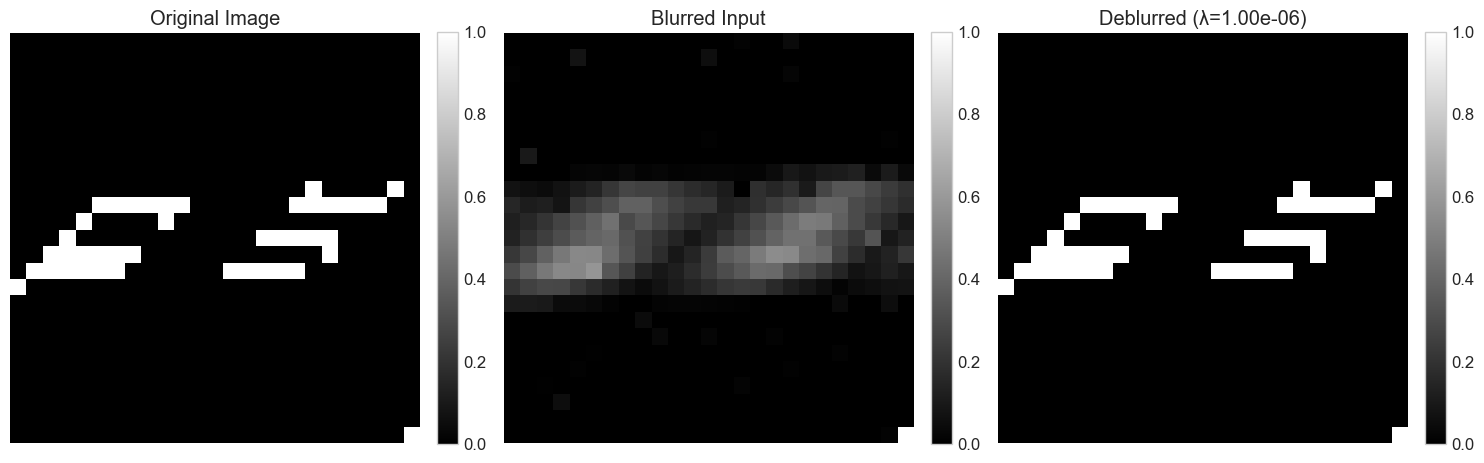

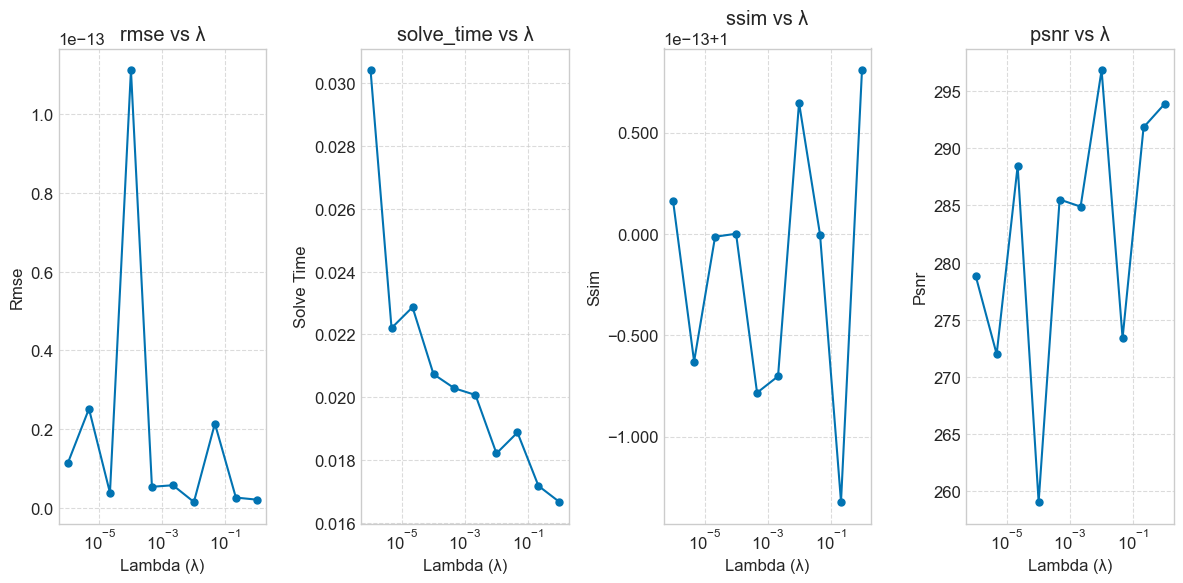


Analyzing noise sensitivity...

Analyzing noise level: 0.0%

Running lambda sensitivity analysis with 8 values


  0%|          | 0/8 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e-16, 2e+00]
Presolving model
472 rows, 799 cols, 20192 nonzeros  0s
430 rows, 428 cols, 16602 nonzeros  0s
Presolve : Reductions: rows 430(-818); columns 428(-820); elements 16602(-35334)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.6583148129e+00 Pr: 215(2.14864) 0s
        290     9.1108708014e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 290
Objective value     :  9.1108708014e+00
Relative P-D gap    :  6.0441052476e-15
HiGHS run time      :          0.01
Solved in 0.02s
RMSE: 0.0000, PSNR: 278.84 dB
Sparsity: 93.4%
λ=1.00e-06: RMSE=0.0000, PSNR=278.84 dB, SSIM=1.0000
Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c

  0%|          | 0/8 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [4e-04, 2e+00]
Presolving model
824 rows, 1036 cols, 35020 nonzeros  0s
810 rows, 816 cols, 27944 nonzeros  0s
Presolve : Reductions: rows 810(-438); columns 816(-432); elements 27944(-23992)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     3.3428691860e-01 Pr: 405(18.07) 0s
        885     1.4476856848e+01 Pr: 0(0) 0s
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
        885     1.4476979122e+01 Pr: 1(0.00159983) 0s
        886     1.4476862300e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 886
Objective value     :  1.4476862300e+01
Relative P-D gap    :  6.0124551388e-15
HiGHS run

  0%|          | 0/8 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [3e-04, 2e+00]
Presolving model
836 rows, 1042 cols, 34974 nonzeros  0s
836 rows, 895 cols, 29586 nonzeros  0s
Presolve : Reductions: rows 836(-412); columns 895(-353); elements 29586(-22350)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 418(73.6463) 0s
        983     3.8169880435e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 983
Objective value     :  3.8169880435e+01
Relative P-D gap    :  2.2338327320e-15
HiGHS run time      :          0.03
Solved in 0.04s
RMSE: 0.1687, PSNR: 15.46 dB
Sparsity: 86.2%
λ=1.00e-06: RMSE=0.1687, PSNR=15.46 dB, SSIM=0.6824
Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c)

  0%|          | 0/8 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [5e-05, 2e+00]
Presolving model
814 rows, 1031 cols, 34556 nonzeros  0s
804 rows, 850 cols, 28616 nonzeros  0s
Presolve : Reductions: rows 804(-444); columns 850(-398); elements 28616(-23320)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.0065387929e+00 Pr: 402(161.714) 0s
        870     7.0001850371e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 870
Objective value     :  7.0001850371e+01
Relative P-D gap    :  8.1202737584e-16
HiGHS run time      :          0.03
Solved in 0.04s
RMSE: 0.1936, PSNR: 14.26 dB
Sparsity: 87.8%
λ=1.00e-06: RMSE=0.1936, PSNR=14.26 dB, SSIM=0.6665
Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c)

  0%|          | 0/8 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e-03, 3e+00]
Presolving model
796 rows, 1022 cols, 33554 nonzeros  0s
786 rows, 872 cols, 28328 nonzeros  0s
Presolve : Reductions: rows 786(-462); columns 872(-376); elements 28328(-23608)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     3.8500485138e+00 Pr: 393(402.24) 0s
        759     1.2841682158e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 759
Objective value     :  1.2841682158e+02
Relative P-D gap    :  2.2132388173e-15
HiGHS run time      :          0.02
Solved in 0.03s
RMSE: 0.2634, PSNR: 11.59 dB
Sparsity: 87.3%
λ=1.00e-06: RMSE=0.2634, PSNR=11.59 dB, SSIM=0.5639
Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 

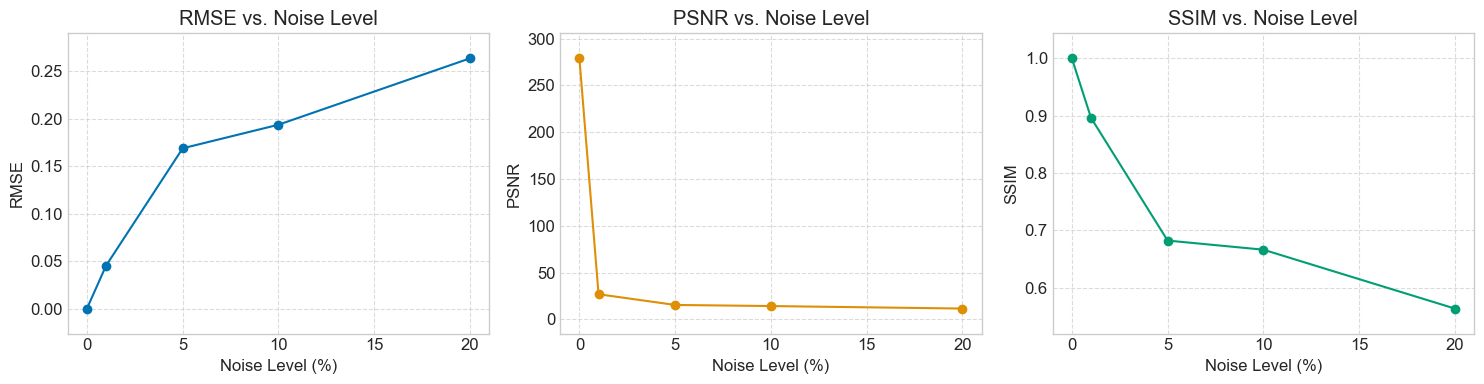


Analysis complete!


In [6]:
def main():
    # Initialize all components
    data_loader = DataLoader(seed=42)
    lp_solver = LPSolver(verbose=True)
    analyzer = Analyzer(verbose=True)
    visualizer = ResultVisualizer(figsize=(15, 5))

    # 1. Load data
    print("Loading data...")
    # Change this line to pass example_num as a keyword argument only
    x_tilde, A, x_true = data_loader.load_data(example_num=0)
    

    # 2. Run lambda sensitivity analysis
    print("\nRunning lambda sensitivity analysis...")
    results = analyzer.run_lambda_sensitivity(
        data_loader=data_loader,         
        lp_solver=lp_solver,
        x_tilde=x_tilde,
        A=A,
        x_true=x_true,
        n_lambda=10,
        lambda_range=(1e-6, 1.0)
    )
    
    # 3. Find and use optimal lambda
    optimal_lambda, opt_idx = analyzer.find_optimal_lambda(results, metric='rmse')
    print(f"\nOptimal lambda: {optimal_lambda:.2e}")
    
    # 4. Visualize results
    print("\nGenerating visualizations...")
    visualizer.plot_comparison(
        x_tilde=x_tilde,
        x_opt=results[opt_idx]['x_opt'],
        x_true=x_true,
        titles={
            'true': 'Original Image',
            'blurred': 'Blurred Input',
            'deblurred': f'Deblurred (λ={optimal_lambda:.2e})'
        },
    )
    
    visualizer.plot_Lambda_vs_metrics(
        results=results,
        metrics=['rmse', 'solve_time', 'ssim', 'psnr'],
        logx=True,
        highlight_optimal=True,
    )
    
    # 5. Run noise analysis
    print("\nAnalyzing noise sensitivity...")
    noise_results = analyzer.analyze_noise_sensitivity(
        data_loader=data_loader,
        lp_solver=lp_solver,
        x_tilde=x_tilde,
        A=A,
        x_true=x_true,
        noise_levels=[0.0, 0.01, 0.05, 0.1, 0.2]
    )
    
    # 6. Visualize noise analysis
    visualizer.plot_noise_analysis(
        noise_results=noise_results,
        metrics=['rmse', 'psnr', 'ssim']
    )

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

In [ ]:
def main():
    # Initialize all components
    data_loader = DataLoader(seed=42)
    lp_solver = LPSolver(verbose=True)
    analyzer = Analyzer(verbose=True)
    visualizer = ResultVisualizer(figsize=(15, 5))

    # 1. Load data
    print("Loading data...")
    # Change this line to pass example_num as a keyword argument only
    x_tilde, A, x_true = data_loader.load_data(example_num=1)
    
    # 2. Run lambda sensitivity analysis
    print("\nRunning lambda sensitivity analysis...")
    results = analyzer.run_lambda_sensitivity(
        data_loader=data_loader,         
        lp_solver=lp_solver,
        x_tilde=x_tilde,
        A=A,
        x_true=x_true,
        n_lambda=10,
        lambda_range=(1e-6, 1.0)
    )
    
    # 3. Find and use optimal lambda
    optimal_lambda, opt_idx = analyzer.find_optimal_lambda(results, metric='rmse')
    print(f"\nOptimal lambda: {optimal_lambda:.2e}")
    
    # 4. Visualize results
    print("\nGenerating visualizations...")
    visualizer.plot_comparison(
        x_tilde=x_tilde,
        x_opt=results[opt_idx]['x_opt'],
        x_true=x_true,
        titles={
            'true': 'Original Image',
            'blurred': 'Blurred Input',
            'deblurred': f'Deblurred (λ={optimal_lambda:.2e})'
        },
    )
    
    visualizer.plot_Lambda_vs_metrics(
        results=results,
        metrics=['rmse', 'solve_time', 'ssim', 'psnr'],
        logx=True,
        highlight_optimal=True,
    )
    
    # 5. Run noise analysis
    print("\nAnalyzing noise sensitivity...")
    noise_results = analyzer.analyze_noise_sensitivity(
        data_loader=data_loader,
        lp_solver=lp_solver,
        x_tilde=x_tilde,
        A=A,
        x_true=x_true,
        noise_levels=[0.0, 0.01, 0.05, 0.1, 0.2]
    )
    
    # 6. Visualize noise analysis
    visualizer.plot_noise_analysis(
        noise_results=noise_results,
        metrics=['rmse', 'psnr', 'ssim']
    )

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

Loading data...

Loaded Example 1:
  x_tilde: (2304,), range: [0.00, 1.00]
  A: (2304, 2304), condition number: 2.51e+17

Running lambda sensitivity analysis...

Running lambda sensitivity analysis with 10 values


  0%|          | 0/10 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [5e-01, 4e+00]
Presolving model
4588 rows, 4598 cols, 213602 nonzeros  0s
4588 rows, 4598 cols, 213602 nonzeros  0s
Presolve : Reductions: rows 4588(-20); columns 4598(-10); elements 213602(-958)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      16338     2.7116022428e+01 Pr: 2248(881.319) 5s
      25248     2.8534883535e+01 Pr: 2086(2.17047) 10s
      31599     2.8762803365e+01 Pr: 1687(1.9556) 16s
      35740     2.8863855353e+01 Pr: 1640(1.01674) 21s
      39585     2.8917734804e+01 Pr: 1941(2.15263) 26s


Loading data...

Loaded Example 2:
  x_tilde: (4321,), range: [0.26, 1.00]
  A: (4321, 4321), condition number: 1.65e+05

Running lambda sensitivity analysis...

Running lambda sensitivity analysis with 10 values


  0%|          | 0/10 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+00]
Presolving model
8062 rows, 8352 cols, 376118 nonzeros  0s
8020 rows, 8037 cols, 370722 nonzeros  0s
Presolve : Reductions: rows 8020(-622); columns 8037(-605); elements 370722(-31762)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      14453     9.6575475528e+01 Pr: 3956(225.593) 5s
      23747     1.1094299891e+02 Pr: 3857(37.8359) 10s
      32370     1.1799525670e+02 Pr: 3653(12.4309) 15s
      40028     1.2082080616e+02 Pr: 3740(17.1774) 20s
      47282     1.2215376030e+02 Pr: 2972(2.17657) 25s
      54727     1.2264131886e+02 Pr: 2912(2.0715) 31s
      62194     1.2277041290e+02 Pr: 2353(0.173954) 36s
      68165     1.2278551081e+02 Pr: 0(0) 39s
      68165

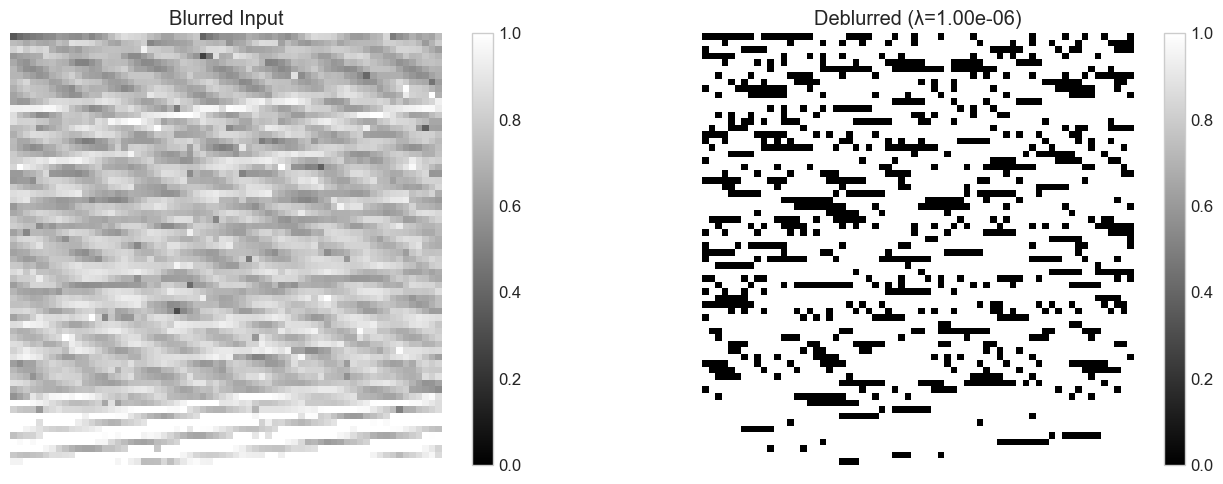

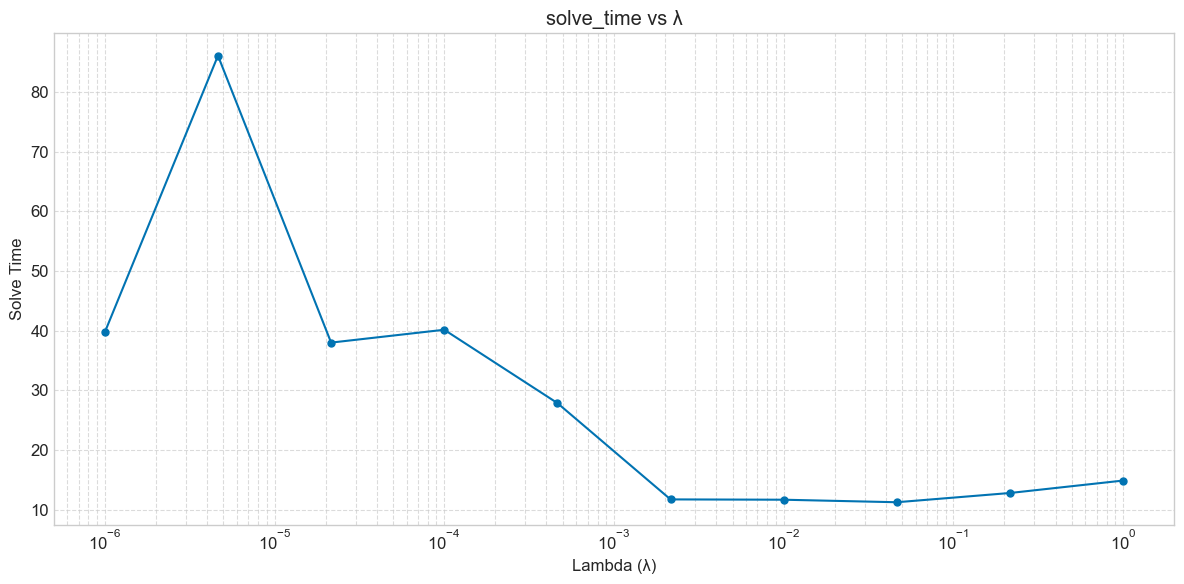


Analyzing noise sensitivity...

Analyzing noise level: 0.0%

Running lambda sensitivity analysis with 8 values


  0%|          | 0/8 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+00]
Presolving model
8062 rows, 8352 cols, 376118 nonzeros  0s
8020 rows, 8037 cols, 370722 nonzeros  0s
Presolve : Reductions: rows 8020(-622); columns 8037(-605); elements 370722(-31762)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      14197     9.5906905208e+01 Pr: 3965(275.266) 5s
      23747     1.1094299891e+02 Pr: 3857(37.8359) 10s
      32038     1.1773379001e+02 Pr: 3916(154.182) 16s
      36905     1.1979142717e+02 Pr: 3956(101.978) 21s
      40028     1.2082080616e+02 Pr: 3740(17.1774) 26s
      43422     1.2164935074e+02 Pr: 3233(3.03034) 31s
      47068     1.2213667497e+02 Pr: 2634(1.00163) 37s
      52983     1.2257081827e+02 Pr: 3295(5.0399) 42s
   

  0%|          | 0/8 [00:00<?, ?it/s]

Running HiGHS 1.8.0 (git hash: 222cce7): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [1e-06, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+00]
Presolving model
8334 rows, 8488 cols, 388524 nonzeros  0s
8332 rows, 8398 cols, 385192 nonzeros  0s
Presolve : Reductions: rows 8332(-310); columns 8398(-244); elements 385192(-17292)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      12919     1.5067965496e+02 Pr: 4102(1314.62) 5s
      23227     1.8625358823e+02 Pr: 3871(970.862) 10s
      33335     1.9551498556e+02 Pr: 3277(23.0611) 15s
      43942     1.9960190088e+02 Pr: 2482(6.61564) 20s
      54010     2.0112681008e+02 Pr: 0(0) 25s
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
      54010     2.0113026019e+02 Pr: 3(0.00398629) 25s
      54018     2.011268

In [ ]:
def main():
    # Initialize all components
    data_loader = DataLoader(seed=42)
    lp_solver = LPSolver(verbose=True)
    analyzer = Analyzer(verbose=True)
    visualizer = ResultVisualizer(figsize=(15, 5))

    # 1. Load data
    print("Loading data...")
    # Change this line to pass example_num as a keyword argument only
    x_tilde, A, x_true = data_loader.load_data(example_num=2)
    
    # 2. Run lambda sensitivity analysis
    print("\nRunning lambda sensitivity analysis...")
    results = analyzer.run_lambda_sensitivity(
        data_loader=data_loader,         
        lp_solver=lp_solver,
        x_tilde=x_tilde,
        A=A,
        x_true=x_true,
        n_lambda=10,
        lambda_range=(1e-6, 1.0)
    )
    
    # 3. Find and use optimal lambda
    optimal_lambda, opt_idx = analyzer.find_optimal_lambda(results, metric='rmse')
    print(f"\nOptimal lambda: {optimal_lambda:.2e}")
    
    # 4. Visualize results
    print("\nGenerating visualizations...")
    visualizer.plot_comparison(
        x_tilde=x_tilde,
        x_opt=results[opt_idx]['x_opt'],
        x_true=x_true,
        titles={
            'true': 'Original Image',
            'blurred': 'Blurred Input',
            'deblurred': f'Deblurred (λ={optimal_lambda:.2e})'
        },
    )
    
    visualizer.plot_Lambda_vs_metrics(
        results=results,
        metrics=['rmse', 'solve_time', 'ssim', 'psnr'],
        logx=True,
        highlight_optimal=True,
    )
    
    # 5. Run noise analysis
    print("\nAnalyzing noise sensitivity...")
    noise_results = analyzer.analyze_noise_sensitivity(
        data_loader=data_loader,
        lp_solver=lp_solver,
        x_tilde=x_tilde,
        A=A,
        x_true=x_true,
        noise_levels=[0.0, 0.01, 0.05, 0.1, 0.2]
    )
    
    # 6. Visualize noise analysis
    visualizer.plot_noise_analysis(
        noise_results=noise_results,
        metrics=['rmse', 'psnr', 'ssim']
    )

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()